In [49]:
import numpy as np
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import pickle



# Get dataset

In [3]:
path = "resource/input/amazon-reviews/train.csv"
corpus = pd.read_csv(path,header=None)
corpus.columns = ['Polarity','Product','Review']
corpus.head(10)

,Polarity,Product,Review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,2,an absolute masterpiece,I am quite sure any of you actually taking the...
6,1,Buyer beware,"This is a self-published book, and if you want..."
7,2,Glorious story,I loved Whisper of the wicked saints. The stor...
8,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...


### Explore the dataset

How many dataset?

In [4]:
corpus.shape

(3600000, 3)

How many positive and negative reviews

In [5]:
corpus['Polarity'].value_counts().sort_index()

Polarity
1    1800000
2    1800000
Name: count, dtype: int64

SSS method

In [6]:
sample_proportion = 0.3  # Represents 30%
sample_size = int(sample_proportion * len(corpus))  # Ensure integer size

# Create the stratified shuffle split object with the correct sample size
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

# Split the data using stratified sampling
for train_index, test_index in sss.split(corpus, corpus["Polarity"]):
    sampled_data = corpus.iloc[test_index]

sampled_data

,Polarity,Product,Review
2529514,1,I'm quite the angry customer,I purchased this item today thinking it was th...
3275761,1,GooseBumps are at it again!,This book didn't even deserve one star! It was...
1192928,1,"Been there, done that","Some of the scenes are quite predictable, and ..."
3419995,1,I' was dissapointed,Really I think that this work were the worst f...
1847955,2,iPod Touch 2G doesn't charge on dock,When I docked my new iPod Touch 2nd generation...
...,...,...,...
2981390,1,Too many mistakes ...,Too many mistakes for my taste :( There were s...
1780976,2,madonna confessions tour cd/dvd,great dvd! i wish the cd had all the songs of ...
520179,2,Worth your time,I am a student at a top 5 law school. This boo...
640481,1,Don't Buy,"Completely useless. Expensive Seranwrap, essen..."


In [7]:
sampled_data.shape

(1080000, 3)

In [8]:
negative_sampled_data = sampled_data[sampled_data["Polarity"] == 1]
negative_sampled_data.head(10)

,Polarity,Product,Review
2529514,1,I'm quite the angry customer,I purchased this item today thinking it was th...
3275761,1,GooseBumps are at it again!,This book didn't even deserve one star! It was...
1192928,1,"Been there, done that","Some of the scenes are quite predictable, and ..."
3419995,1,I' was dissapointed,Really I think that this work were the worst f...
2565399,1,Under Rug Swept...Thats is where it Belongs,I never learn my lesson. I was a bog Alanis fa...
661361,1,Rated B for boring,This has to be the most boring movie I've ever...
2180157,1,A lie,Frey was urged by his agent from novel to non-...
453106,1,not quite up to snuff,"Although I usually enjoy Linda Howard's books,..."
685902,1,THIS LIST MUST BE A JOKE,RIC FLAIR IS THE GREATEST WRESTLER EVER. Hogan...
2304326,1,WHY DO YOU MAKE PRODUCTS LIKE THIS?????,Was able to use this unit for a couple of days...


Positive

In [9]:
positive_sampled_data = sampled_data[sampled_data["Polarity"] == 2]
positive_sampled_data.head(10)

,Polarity,Product,Review
1847955,2,iPod Touch 2G doesn't charge on dock,When I docked my new iPod Touch 2nd generation...
2605464,2,"Not scary once so ever, but still well written",Rita Hayworth And The Shawshank Redemption and...
3093451,2,"History, time travel and romance without being...",Ms Gabaldon has achieved a superb blend of gen...
2985377,2,crude but true,The first time I read this book the informatio...
1498361,2,Excelent,Excelent product!!!My son really enjoy it!!I r...
3325903,2,you have to see this,This is a movie that stand up there with the b...
572953,2,big collection,very comprehensive collection of Hitchcock mov...
647554,2,NOT A FAKE,"I ordered this product from Amazon, and like m..."
1334054,2,I Love Tom Jones,"Tom Jones is the man, he was back in the old d..."
1877679,2,Would buy againBought,Bought this for my nephew and he loves it. Gre...


# Clean dataset

Fuction - for decrease the number of polarity
* `0` for positive 
* `1` for negative

In [10]:
def polarity_optimisation(num):
    if(num == 2):
        return 0
    else:
        return 1

In [11]:
def pre_processor(corpus):
    # Optimize polarity (replace with appropriate logic)
    corpus.loc[:, 'Polarity'] = corpus['Polarity'].apply(polarity_optimisation)

    # Remove whitespace
    corpus.loc[:, 'Review'] = corpus['Review'].apply(lambda x: x.strip())

    # Convert to lowercase
    corpus.loc[:, 'Review'] = corpus['Review'].apply(lambda x: x.lower())

    # Remove non-English characters
    pattern_english = re.compile(r'[^a-zA-Z\s]')
    corpus.loc[:, 'Review'] = corpus['Review'].apply(lambda x: re.sub(pattern_english, '', x))

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    corpus.loc[:, 'Review'] = corpus['Review'].apply(
        lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words])
    )

    # Apply stemming
    stemmer = PorterStemmer()
    corpus.loc[:, 'Review'] = corpus['Review'].apply(
        lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)])
    )

    return corpus

In [12]:
processed_dataset = pre_processor(sampled_data)
processed_dataset


,Polarity,Product,Review
2529514,1,I'm quite the angry customer,purchas item today think entir blaze battl see...
3275761,1,GooseBumps are at it again!,book didnt even deserv one star poorli written...
1192928,1,"Been there, done that",scene quit predict typic hollywood movi also p...
3419995,1,I' was dissapointed,realli think work worst marcu robert estoy arr...
1847955,0,iPod Touch 2G doesn't charge on dock,dock new ipod touch nd gener screen show charg...
...,...,...,...
2981390,1,Too many mistakes ...,mani mistak tast mani obviou mistak book york ...
1780976,0,madonna confessions tour cd/dvd,great dvd wish cd song concert includ instead ...
520179,0,Worth your time,student top law school book outlin specif syst...
640481,1,Don't Buy,complet useless expens seranwrap essenti big h...


Text(0, 0.5, 'Text Length')

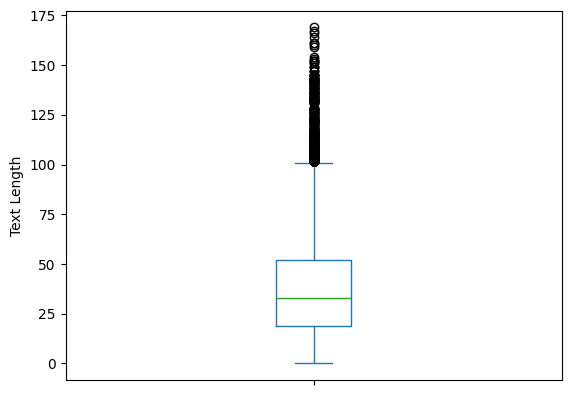

In [14]:
text_length = pd.Series([len(review.split()) for review in processed_dataset["Review"]])
text_length.plot(kind="box")
plt.ylabel("Text Length")

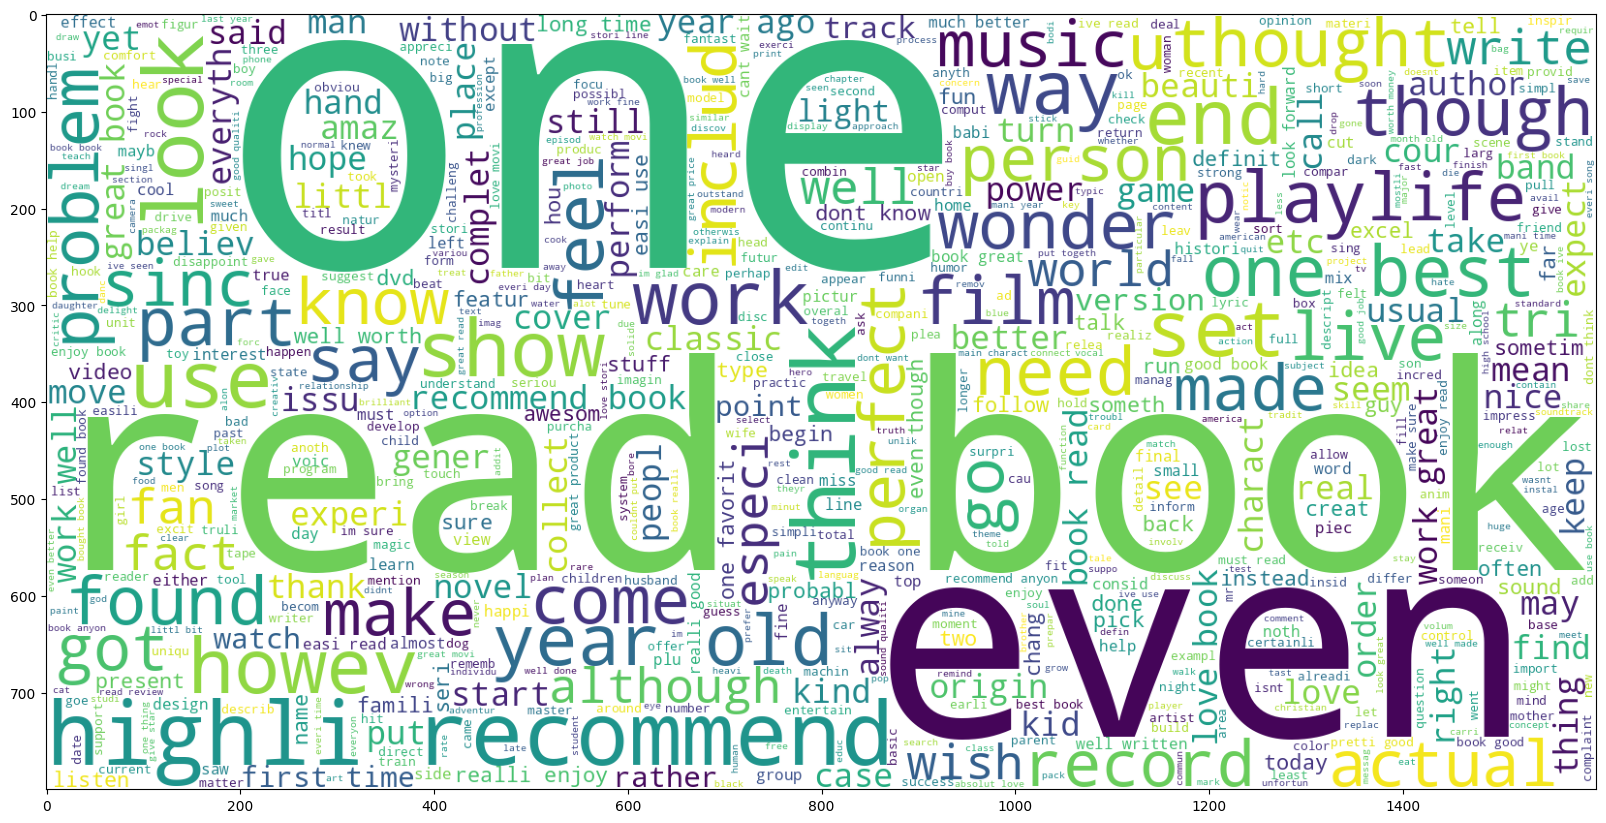

In [18]:
# Negative Review WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(processed_dataset[processed_dataset["Polarity"]==0].Review))
plt.imshow(wc1)

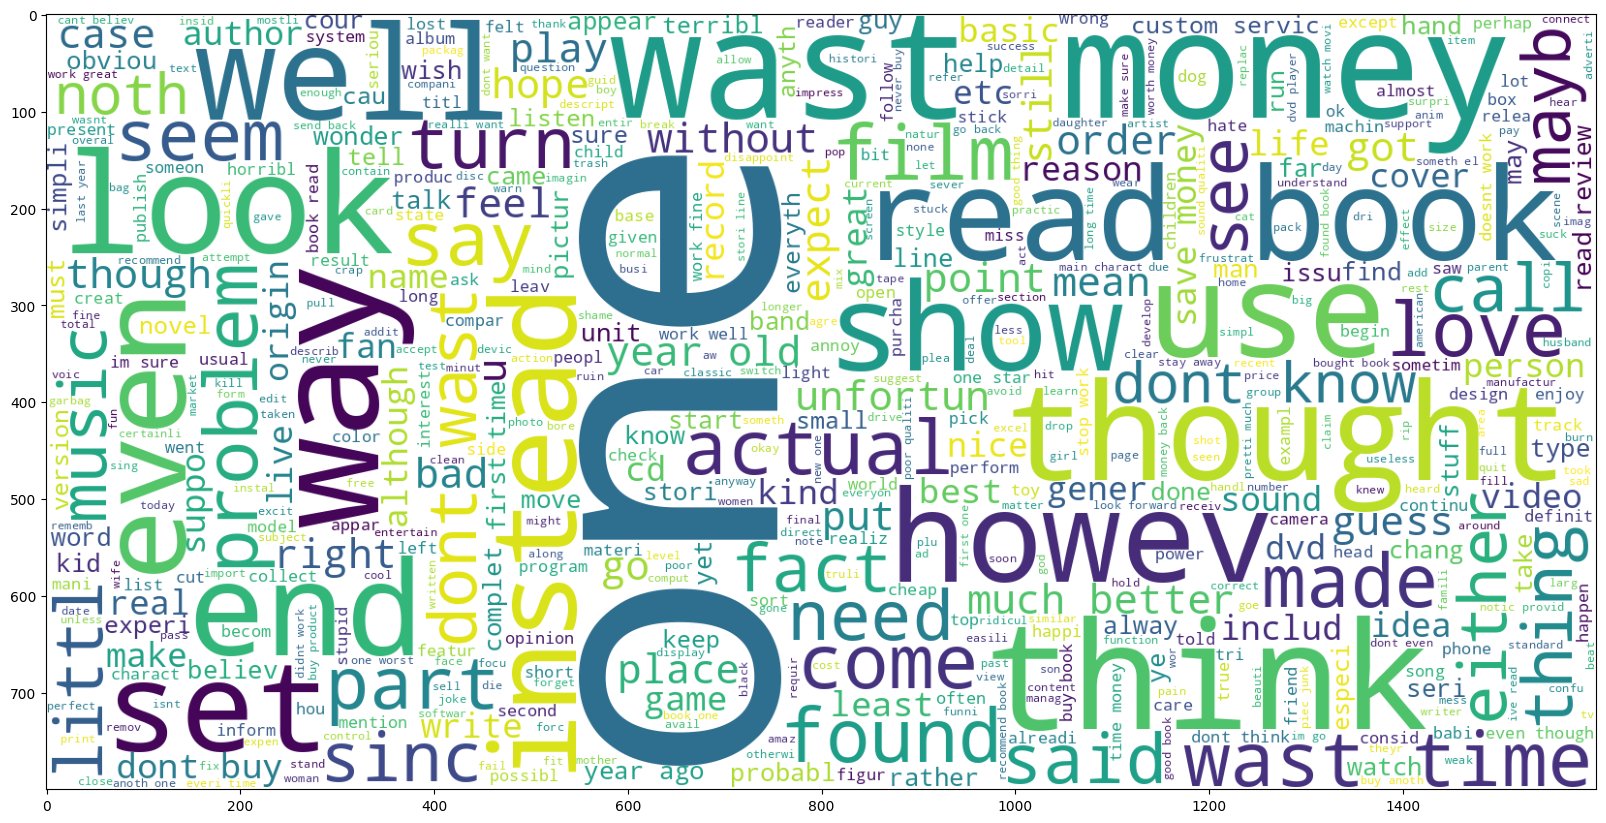

In [19]:
# Negative Review WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(processed_dataset[processed_dataset["Polarity"]==1].Review))
plt.imshow(wc1)

In [21]:
# Instantiate the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(processed_dataset['Review'])
y_train = processed_dataset['Polarity']

# Initialize the classifier
clf = LinearSVC()

# Train the classifier
clf.fit(X_train_tfidf, y_train)

/Users/CAMT/anaconda3/envs/SE-482/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [26]:
# Read the test dataset
test_corpus = pd.read_csv('resource/input/amazon-reviews/test.csv', header=None, nrows=40000)
test_corpus.columns = ['Polarity', 'Product', 'Review']  # Assuming this is correct
test_corpus = test_corpus[['Polarity', 'Review']].reset_index(drop=True)


In [27]:
# Define the preprocessing function
def pre_processor(corpus):
    # Remove whitespace
    corpus['Review'] = corpus['Review'].str.strip()

    # Convert to lowercase
    corpus['Review'] = corpus['Review'].str.lower()

    # Remove non-English characters
    pattern_english = re.compile(r'[^a-zA-Z\s]')
    corpus['Review'] = corpus['Review'].apply(lambda x: re.sub(pattern_english, '', x))

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    corpus['Review'] = corpus['Review'].apply(
        lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words])
    )

    # Apply stemming
    stemmer = PorterStemmer()
    corpus['Review'] = corpus['Review'].apply(
        lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)])
    )

    return corpus


In [30]:
# Preprocessing test data
test_corpus = pre_processor(test_corpus)
test_corpus['Polarity'] = test_corpus['Polarity'].apply(polarity_optimisation)

In [31]:
test_corpus.head(10)

,Polarity,Review
0,0,love pat one great voic gener listen cd year s...
1,0,despit fact play small portion game music hear...
2,1,bought charger jul work ok design nice conveni...
3,0,check maha energi websit powerex mhcf charger ...
4,0,review quit bit combo player hesit due unfavor...
5,1,also began incorrect disc problem ive read vcr...
6,1,love style coupl year dvd give problem doesnt ...
7,1,scroll dvd menu set vertic triangl key select ...
8,0,exot tale orient dr shen fu weird tale magazin...
9,1,firstlyi enjoy format tone book author address...


In [32]:
X_test_tfidf = tfidf_vectorizer.transform(test_corpus['Review'])

In [33]:
y_test = test_corpus['Polarity']
y_pred = clf.predict(X_test_tfidf)

In [35]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.866

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87     20359
           1       0.87      0.85      0.86     19641

    accuracy                           0.87     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.87      0.87      0.87     40000



In [64]:
# Customised pre_processor
def customised_pre_processor(review):
    review = review.strip()

    # Convert to lowercase
    review = review.lower()

    # Remove non-English characters
    review = re.sub(r'[^a-zA-Z\s]', '', review)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    review = ' '.join([word for word in word_tokenize(review) if word.lower() not in stop_words])

    # Apply stemming
    stemmer = PorterStemmer()
    review = ' '.join([stemmer.stem(word) for word in word_tokenize(review)])
    return review

In [44]:
def sentiment_analysis(text):
    # Preprocess the input text
    preprocessed_text = customised_pre_processor(text)
    
    # Transform the text using the trained tfidf_vectorizer
    features = tfidf_vectorizer.transform([preprocessed_text])
    
    # Predict using the trained classifier
    prediction = clf.predict(features)[0]
    
    # Return the sentiment
    if prediction == 1:
        return "Negative"
    else:
        return "Positive"

In [65]:
pickle_out = open("resource/output/tfidf_vectorizer.pkl", "wb")
pickle.dump(tfidf_vectorizer, pickle_out)
pickle_out.close()

pickle_out = open("resource/output/preprocess.pkl", "wb")
pickle.dump(customised_pre_processor, pickle_out)
pickle_out.close()

pickle_out = open("resource/output/clf.pkl", "wb")
pickle.dump(clf, pickle_out)
pickle_out.close()


In [66]:
sentiment_analysis("terrible product")

'Negative'

In [67]:
sentiment_analysis("cool, i bough it for 3 times!")

'Positive'